## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere

import sfacts as sf

from tqdm import tqdm

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [5]:
species_id = 102506

fit = sf.data.World.load(f'data/zshi.sp-{species_id}.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 0.05

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 9232, 'position': 75942, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(0.00055164, dtype=float32)
Coordinates:
    species_id  int64 102506
Frozen(SortedKeysDict({'strain': 123, 'sample': 9232, 'position': 75942, 'allele': 2}))


In [6]:
ref = sf.data.Metagenotypes.load(f'data/gtprodb.sp-{species_id}.genotype.nc').mlift('sel', position=fit.position).to_estimated_genotypes(pseudo=0)
ref.sizes

Frozen({'strain': 1000, 'position': 75942})

(array([16920., 14942.,  9039.,  5591.,  5193.,  5936.,  7446.,  5189.,
         4404.,  1282.]),
 array([0.01  , 0.0635, 0.117 , 0.1705, 0.224 , 0.2775, 0.331 , 0.3845,
        0.438 , 0.4915, 0.545 ]),
 <BarContainer object of 10 artists>)

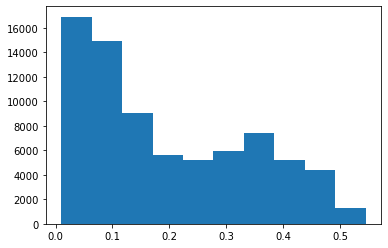

In [7]:
plt.hist(ref.mean('strain'))

In [8]:
# TODO: Decide if I want to discretize here.
ref_dist = ref.discretized().pdist()
fit_dist = fit_genotypes.discretized().pdist()

In [9]:
dedup_thresh = 0.05

ref_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(ref_dist),
    index=ref_dist.columns,
)
fit_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(fit_dist),
    index=fit_dist.columns.astype(int),
)

ref_clust.value_counts()

0      114
7       68
11      58
61      42
31      42
      ... 
108      1
107      1
104      1
103      1
175      1
Length: 176, dtype: int64

In [10]:
fit_clust.value_counts().sort_values(ascending=False).head()

0     3
5     2
2     2
34    1
3     1
dtype: int64

In [11]:
ref_dedup = sf.Genotypes(ref.to_series().unstack('strain').groupby(ref_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())
fit_dedup = sf.Genotypes(fit_genotypes.to_series().unstack('strain').groupby(fit_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())

In [12]:
(ref.sizes['strain'], ref_dedup.sizes['strain']), (fit_genotypes.sizes['strain'], fit_dedup.sizes['strain'])

((1000, 176), (123, 119))

In [13]:
from scipy.spatial.distance import pdist, squareform

g = sf.data.Genotypes.concat(dict(
    ref=ref_dedup,
    fit=fit_dedup,
), dim='strain')

dist = pd.DataFrame(g.discretized().pdist(), index=g.strain, columns=g.strain)

In [14]:
clust_thresh = 0.15

all_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=clust_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(dist),
    index=g.strain,
)

clust_type = all_clust.index.to_series().str[:3]

In [15]:
from itertools import product
    
def count_clust_types(clust, key):
    clust_types = (
        clust
        .to_frame(name='clust')
        .assign(key=key)
        .groupby(['clust', 'key'])
        .apply(len)
        .unstack(fill_value=0)
    )
    all_keys = clust_types.columns.to_list()
    all_possible_clust_types = pd.DataFrame(product([True, False], repeat=len(all_keys)), columns=all_keys)
    return clust_types, clust_types.apply(lambda x: x > 0).groupby(all_keys).apply(len).reindex(all_possible_clust_types, fill_value=0)

clust_stats, clust_type_tally = count_clust_types(all_clust, clust_type)

clust_type_tally

fit    ref  
True   True     24
       False     8
False  True      8
       False     0
dtype: int64

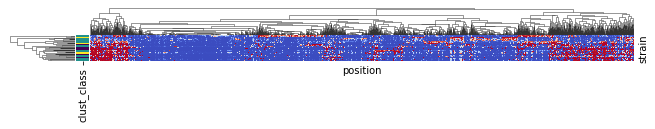

In [16]:
_clust_stats = (
    clust_stats
    .assign(
        tally=lambda x: x.sum(1),
    )
    .assign(only_fit=lambda x: x.ref==0, only_ref=lambda x: x.fit==0)
    .assign(both=lambda x: ~(x.only_fit | x.only_ref))
    .assign(clust_class=lambda x: x[['only_ref', 'both', 'only_fit']].values.argmax(1))
)

clust_genotypes = sf.Genotypes(g.to_series().unstack('strain').groupby(all_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())

sf.plot.plot_genotype(
    clust_genotypes.random_sample(position=2500),
    row_colors_func=lambda w: _clust_stats[['clust_class']].to_xarray(),
    scaley=1e-2,
    scalex=3e-3,
    yticklabels=0
)

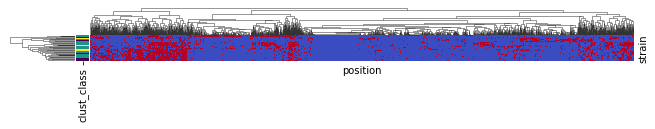

In [17]:
sf.plot.plot_genotype(
    clust_genotypes.discretized().random_sample(position=2500),
    row_colors_func=lambda w: _clust_stats[['clust_class']].to_xarray(),
    scaley=1e-2,
    scalex=3e-3,
    yticklabels=0
)

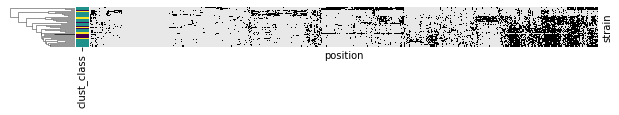

In [45]:
np.random.seed(0)

sf.plot.plot_genotype(
    clust_genotypes.discretized().random_sample(position=3500),
    row_colors_func=lambda w: _clust_stats[['clust_class']].to_xarray(),
    row_linkage_func=lambda w: clust_genotypes.linkage(method='complete'),
    scaley=3e-2,
    scalex=2e-3,
    yticklabels=0,
    dheight=0.001,
    cmap='gray_r',
    norm=mpl.colors.PowerNorm(1, vmin=-0.1, vmax=1.),
)

plt.savefig(f'fig/coclustering_{species_id}.png', dpi=400)

In [19]:
len(_clust_stats)

40

In [20]:
# Count the number of each type of genotype in each type of cluster.
_clust_stats.groupby(['only_fit', 'both', 'only_ref'])[['fit', 'ref']].sum().apply(lambda x: x / x.sum())

key                           fit       ref
only_fit both  only_ref                    
False    False True      0.000000  0.056818
         True  False     0.932773  0.943182
True     False False     0.067227  0.000000

In [21]:
np.random.seed(0)

def permutation_clust_types(clust, key, n=1, progress=False):
    _, observed = count_clust_types(clust, key)
    permutations = []
    for _ in tqdm(range(n), disable=(not progress)):
        perm_clust = pd.Series(np.random.choice(clust.values, size=len(clust), replace=False), index=clust.index)
        permutations.append(count_clust_types(perm_clust, key)[1])
    return observed, pd.DataFrame(permutations)

obs, perm = permutation_clust_types(all_clust, all_clust.index.to_series().str[:3], n=9999, progress=True)

100%|██████████| 9999/9999 [01:08<00:00, 146.55it/s]


In [22]:
obs.to_frame(name='tally').assign(frac=lambda x: x / x.sum())

tally  frac
fit   ref               
True  True      24   0.6
      False      8   0.2
False True       8   0.2
      False      0   0.0

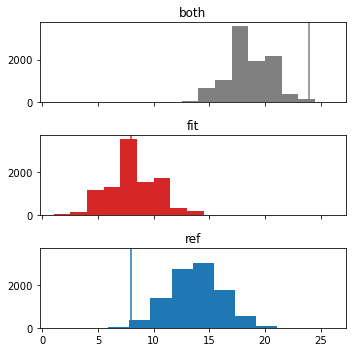

In [23]:
fig, axs = plt.subplots(3, figsize=(5, 5), sharex=True, sharey=True)

for (key, c, label), ax in zip([((True, True), 'grey', 'both'), ((True, False), 'tab:red', 'fit'), ((False, True), 'tab:blue', 'ref')], axs):
    ax.hist(perm[key], color=c)
    ax.axvline(obs[key], color=c, label=label)
    ax.set_title(label)
fig.tight_layout()

In [24]:
def tally_permutation_test(obs, perm):    
    out = {}
    for key in obs.index:
        out[key, '>'] = ((obs[key] > perm[key]).sum())
        out[key, '=='] = ((obs[key] == perm[key]).sum())
        out[key, '<'] = ((obs[key] < perm[key]).sum())
    return pd.Series(out).unstack()

tally_permutation_test(obs, perm).apply(lambda x: x / x.sum(), axis=1)

,<,==,>
"(False, False)",0.000000,1.000000,0.000000
"(False, True)",0.984998,0.010701,0.004300
"(True, False)",0.382438,0.183218,0.434343
"(True, True)",0.000500,0.002300,0.997200


In [25]:
np.random.seed(0)

def permutation_strain_clust_type(clust, key, n=1, progress=False):
    clust_stats, _ = count_clust_types(clust, key)
    observed = clust_stats.groupby((clust_stats > 0).apply(lambda x: tuple(x), axis=1)).sum().stack()
    permutations = []
    for _ in tqdm(range(n), disable=(not progress)):
        perm_clust = pd.Series(np.random.choice(clust.values, size=len(clust), replace=False), index=clust.index)
        perm_clust_stats, _ = count_clust_types(perm_clust, key)
        permutations.append(perm_clust_stats.groupby((perm_clust_stats > 0).apply(lambda x: tuple(x), axis=1)).sum().stack())
    return observed, pd.DataFrame(permutations)

obs2, perm2 = permutation_strain_clust_type(all_clust, all_clust.index.to_series().str[:3], n=9999, progress=True)

100%|██████████| 9999/9999 [02:06<00:00, 78.75it/s]


In [26]:
obs2

               key
(False, True)  fit      0
               ref     10
(True, False)  fit      8
               ref      0
(True, True)   fit    111
               ref    166
dtype: int64

In [27]:
perm2

(False, True)     (True, False)     (True, True)     
key            fit ref           fit ref          fit  ref
0                0  18            14   0          105  158
1                0  22             8   0          111  154
2                0  24            11   0          108  152
3                0  19             9   0          110  157
4                0  27             6   0          113  149
...            ...  ..           ...  ..          ...  ...
9994             0  23            14   0          105  153
9995             0  14            15   0          104  162
9996             0  20            13   0          106  156
9997             0  26            12   0          107  150
9998             0  24            13   0          106  152

[9999 rows x 6 columns]

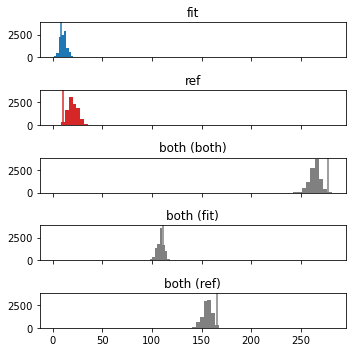

In [28]:
fig, axs = plt.subplots(5, figsize=(5, 5), sharex=True, sharey=True)

for (key, c, label), ax in zip(
    [
        (((True, False), 'fit'), 'tab:blue', 'fit'),
        (((False, True), 'ref'), 'tab:red', 'ref'),
    ],
    axs
):
    ax.hist(perm2[key], color=c)
    ax.axvline(obs2[key], color=c, label=label)
    ax.set_title(label)
    
    

ax = axs[2]
c = 'grey'
ax.hist(perm2[((True, True), 'fit')] + perm2[((True, True), 'ref')], color=c)
ax.axvline(obs2[((True, True), 'fit')] + obs2[((True, True), 'ref')], c=c)
ax.set_title('both (both)')

ax = axs[3]
c = 'grey'
ax.hist(perm2[((True, True), 'fit')], color=c)
ax.axvline(obs2[((True, True), 'fit')], c=c)
ax.set_title('both (fit)')

ax = axs[4]
c = 'grey'
ax.hist(perm2[((True, True), 'ref')], color=c)
ax.axvline(obs2[((True, True), 'ref')], c=c)
ax.set_title('both (ref)')

fig.tight_layout()

In [35]:
(
    (perm2[((True, True), 'fit')] + perm2[((True, True), 'ref')])
    >=
    (obs2[((True, True), 'fit')] + obs2[((True, True), 'ref')])
).mean()

0.0023002300230023

In [36]:
(
    perm2[((True, False), 'fit')]
    >= 
    obs2[((True, False), 'fit')]
).mean()

0.8127812781278128